Most of the fields are self-explanatory. The following are descriptions for those that aren't.

- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are - closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. -"Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

In [2]:
X_train = pd.read_csv("data/train.csv", parse_dates=[2], low_memory=False)
X_test = pd.read_csv("data/test.csv", parse_dates=[3], low_memory=False)
store = pd.read_csv("data/store.csv")

In [3]:
print(X_train["Date"].min(), X_train["Date"].max())
X_train.sort_values(["Date"], inplace=True, kind="mergesort")
X_train.reset_index(drop=True, inplace=True)

2013-01-01 00:00:00 2015-07-31 00:00:00


In [4]:
X_test["Open"] = X_test["Open"].fillna(1)

In [5]:
# TODO: how do handle missing values regarding competitor store
store.fillna(0, inplace=True)

In [6]:
X_train = pd.merge(X_train, store, on="Store", how="left")
X_test = pd.merge(X_test, store, on="Store", how="left")

In [7]:
assert np.all(X_train[X_train["Open"] == 0]["Sales"] == 0)
X_train = X_train[X_train["Open"] == 1]
del X_train["Open"]
test_close_ind = np.where(X_test["Open"] == 0)[0]
del X_test["Open"]

In [8]:
y_train = np.array(X_train["Sales"])
X_train.drop("Sales", axis=1, inplace=True)
X_train.drop("Customers", axis=1, inplace=True)
test_ID = X_test["Id"]
X_test.drop("Id", axis=1, inplace=True)

In [9]:
y_train = np.log1p(y_train)

In [10]:
num_train = X_train.shape[0]
all_data = pd.concat((X_train, X_test), ignore_index=True)

In [11]:
all_data['year'] = all_data['Date'].dt.year
all_data['month'] = all_data['Date'].dt.month
all_data['day'] = all_data['Date'].dt.day
assert np.all(all_data["DayOfWeek"] - 1 == all_data['Date'].dt.dayofweek)
all_data['dayofyear'] = all_data['Date'].dt.dayofyear
all_data['weekofyear'] = all_data['Date'].dt.weekofyear
all_data.drop("Date", axis=1, inplace=True)

In [12]:
all_data["CompetitionOpen"] = ((all_data["year"] - all_data["CompetitionOpenSinceYear"]) * 12
                               + (all_data["month"] - all_data["CompetitionOpenSinceMonth"]))
all_data["CompetitionOpen"] = all_data["CompetitionOpen"].apply(lambda x: x if x > 0 else 0)

In [13]:
all_data["PromoOpen"] = ((all_data["year"] - all_data["Promo2SinceYear"]) * 12
                         + (all_data["weekofyear"] - all_data["Promo2SinceWeek"]) / 4)
all_data["PromoOpen"] = all_data["PromoOpen"].apply(lambda x: x if x > 0 else 0)

In [14]:
month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
def check(row):
    if isinstance(row['PromoInterval'], str) and month2str[row['month']] in row['PromoInterval']:
        return 1
    else:
        return 0
all_data['IsPromoMonth'] =  all_data.apply(lambda row: check(row), axis=1) 
all_data.drop("PromoInterval", axis=1, inplace=True)

In [15]:
all_data["StateHoliday"] = LabelEncoder().fit_transform(all_data["StateHoliday"])
all_data["StoreType"] = LabelEncoder().fit_transform(all_data["StoreType"])
all_data["Assortment"] = LabelEncoder().fit_transform(all_data["Assortment"])

In [16]:
X_train = all_data[:num_train]
X_test = all_data[num_train:]

In [17]:
def rmspe(y_true, y_pred):
    y_pred = y_pred[y_true != 0]
    y_true = y_true[y_true != 0]
    err = np.sqrt(np.mean((1 - y_pred / y_true) ** 2))
    return err

def rmspe_xgb(y_pred, y_true):
    y_true = y_true.get_label()
    err = rmspe(np.expm1(y_true), np.expm1(y_pred))
    return "rmspe", err

In [32]:
valid_size = 6 * 7 * 1115  # last six weeks
train_size = X_train.shape[0] - valid_size
X_train_1, y_train_1 = X_train[:train_size], y_train[:train_size]
X_train_1, y_train_1 = X_train_1[y_train_1 != 0], y_train_1[y_train_1 != 0]
X_train_2, y_train_2 = X_train[train_size:], y_train[train_size:]
reg = xgb.XGBRegressor(n_estimators=5000, objective="reg:squarederror", random_state=0,
                       tree_method="gpu_hist", gpu_id=0)
reg.fit(X_train_1, y_train_1, eval_set=[(X_train_1, y_train_1), (X_train_2, y_train_2)],
        eval_metric=rmspe_xgb, early_stopping_rounds=50, verbose=50)

[0]	validation_0-rmse:7.44221	validation_1-rmse:7.47029	validation_0-rmspe:0.999524	validation_1-rmspe:0.99954
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 50 rounds.
[50]	validation_0-rmse:0.347806	validation_1-rmse:0.33928	validation_0-rmspe:0.411665	validation_1-rmspe:0.366499
Stopping. Best iteration:
[36]	validation_0-rmse:0.391444	validation_1-rmse:0.391059	validation_0-rmspe:0.384497	validation_1-rmspe:0.348741



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=5000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)

In [33]:
valid_size = 6 * 7 * 1115  # last six weeks
train_size = X_train.shape[0] - valid_size
X_train_1, y_train_1 = X_train[:train_size], y_train[:train_size]
X_train_1, y_train_1 = X_train_1[y_train_1 != 0], y_train_1[y_train_1 != 0]
X_train_2, y_train_2 = X_train[train_size:], y_train[train_size:]
reg = xgb.XGBRegressor(n_estimators=5000, objective="reg:squarederror", max_depth=10,
                       random_state=0, tree_method="gpu_hist", gpu_id=0)
reg.fit(X_train_1, y_train_1, eval_set=[(X_train_1, y_train_1), (X_train_2, y_train_2)],
        eval_metric=rmspe_xgb, early_stopping_rounds=50, verbose=50)

[0]	validation_0-rmse:7.44191	validation_1-rmse:7.46952	validation_0-rmspe:0.999527	validation_1-rmspe:0.999542
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 50 rounds.
[50]	validation_0-rmse:0.200656	validation_1-rmse:0.210576	validation_0-rmspe:0.232724	validation_1-rmspe:0.221141
[100]	validation_0-rmse:0.129238	validation_1-rmse:0.153717	validation_0-rmspe:0.158314	validation_1-rmspe:0.167989
[150]	validation_0-rmse:0.1071	validation_1-rmse:0.138485	validation_0-rmspe:0.125355	validation_1-rmspe:0.150077
[200]	validation_0-rmse:0.097734	validation_1-rmse:0.133312	validation_0-rmspe:0.11102	validation_1-rmspe:0.144331
[250]	validation_0-rmse:0.091789	validation_1-rmse:0.130471	validation_0-rmspe:0.104232	validation_1-rmspe:0.140987
[300]	validation_0-rmse:0.087541	validation_1-rmse:0.128992	validation_0-rmspe:0.098716	validation_1-rmspe:0.139036
[350]	validation_0-rmse:0.083992	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=5000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)

In [34]:
valid_size = 6 * 7 * 1115  # last six weeks
train_size = X_train.shape[0] - valid_size
X_train_1, y_train_1 = X_train[:train_size], y_train[:train_size]
X_train_1, y_train_1 = X_train_1[y_train_1 != 0], y_train_1[y_train_1 != 0]
X_train_2, y_train_2 = X_train[train_size:], y_train[train_size:]
reg = xgb.XGBRegressor(n_estimators=5000, objective="reg:squarederror", max_depth=10,
                       learning_rate=0.03, colsample_bytree=0.9, random_state=0,
                       tree_method="gpu_hist", gpu_id=0)
reg.fit(X_train_1, y_train_1, eval_set=[(X_train_1, y_train_1), (X_train_2, y_train_2)],
        eval_metric=rmspe_xgb, early_stopping_rounds=50, verbose=50)

[0]	validation_0-rmse:8.01953	validation_1-rmse:8.04763	validation_0-rmspe:0.999809	validation_1-rmspe:0.999815
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 50 rounds.
[50]	validation_0-rmse:1.77253	validation_1-rmse:1.78225	validation_0-rmspe:0.820179	validation_1-rmspe:0.821726
[100]	validation_0-rmse:0.457972	validation_1-rmse:0.457909	validation_0-rmspe:0.362464	validation_1-rmspe:0.348768
[150]	validation_0-rmse:0.226389	validation_1-rmse:0.230958	validation_0-rmspe:0.251681	validation_1-rmspe:0.223172
[200]	validation_0-rmse:0.180927	validation_1-rmse:0.190808	validation_0-rmspe:0.228321	validation_1-rmspe:0.202739
[250]	validation_0-rmse:0.158268	validation_1-rmse:0.171849	validation_0-rmspe:0.195965	validation_1-rmspe:0.185743
[300]	validation_0-rmse:0.142233	validation_1-rmse:0.158573	validation_0-rmspe:0.171532	validation_1-rmspe:0.171607
[350]	validation_0-rmse:0.13023	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=0,
             importance_type='gain', learning_rate=0.03, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=5000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)

In [35]:
valid_size = 6 * 7 * 1115  # last six weeks
train_size = X_train.shape[0] - valid_size
X_train_1, y_train_1 = X_train[:train_size], y_train[:train_size]
X_train_1, y_train_1 = X_train_1[y_train_1 != 0], y_train_1[y_train_1 != 0]
X_train_2, y_train_2 = X_train[train_size:], y_train[train_size:]
reg = xgb.XGBRegressor(n_estimators=5000, objective="reg:squarederror", max_depth=10,
                       learning_rate=0.03, colsample_bytree=0.8, random_state=0,
                       tree_method="gpu_hist", gpu_id=0)
reg.fit(X_train_1, y_train_1, eval_set=[(X_train_1, y_train_1), (X_train_2, y_train_2)],
        eval_metric=rmspe_xgb, early_stopping_rounds=50, verbose=50)

[0]	validation_0-rmse:8.01953	validation_1-rmse:8.04775	validation_0-rmspe:0.999809	validation_1-rmspe:0.999815
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 50 rounds.
[50]	validation_0-rmse:1.77262	validation_1-rmse:1.78266	validation_0-rmspe:0.820161	validation_1-rmspe:0.82176
[100]	validation_0-rmse:0.454509	validation_1-rmse:0.453791	validation_0-rmspe:0.361408	validation_1-rmspe:0.346552
[150]	validation_0-rmse:0.230154	validation_1-rmse:0.234169	validation_0-rmspe:0.254846	validation_1-rmspe:0.228245
[200]	validation_0-rmse:0.186425	validation_1-rmse:0.198316	validation_0-rmspe:0.231157	validation_1-rmspe:0.212578
[250]	validation_0-rmse:0.162652	validation_1-rmse:0.176861	validation_0-rmspe:0.206288	validation_1-rmspe:0.19259
[300]	validation_0-rmse:0.142506	validation_1-rmse:0.160074	validation_0-rmspe:0.174454	validation_1-rmspe:0.174617
[350]	validation_0-rmse:0.130002	val

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=0,
             importance_type='gain', learning_rate=0.03, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=5000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)

In [36]:
valid_size = 6 * 7 * 1115  # last six weeks
train_size = X_train.shape[0] - valid_size
X_train_1, y_train_1 = X_train[:train_size], y_train[:train_size]
X_train_1, y_train_1 = X_train_1[y_train_1 != 0], y_train_1[y_train_1 != 0]
X_train_2, y_train_2 = X_train[train_size:], y_train[train_size:]
reg = xgb.XGBRegressor(n_estimators=5000, objective="reg:squarederror", max_depth=10,
                       learning_rate=0.03, colsample_bytree=0.7, random_state=0,
                       tree_method="gpu_hist", gpu_id=0)
reg.fit(X_train_1, y_train_1, eval_set=[(X_train_1, y_train_1), (X_train_2, y_train_2)],
        eval_metric=rmspe_xgb, early_stopping_rounds=50, verbose=50)

[0]	validation_0-rmse:8.01953	validation_1-rmse:8.04775	validation_0-rmspe:0.999809	validation_1-rmspe:0.999815
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 50 rounds.
[50]	validation_0-rmse:1.77318	validation_1-rmse:1.78504	validation_0-rmspe:0.820006	validation_1-rmspe:0.821878
[100]	validation_0-rmse:0.455133	validation_1-rmse:0.457246	validation_0-rmspe:0.361769	validation_1-rmspe:0.348413
[150]	validation_0-rmse:0.230486	validation_1-rmse:0.236969	validation_0-rmspe:0.252773	validation_1-rmspe:0.22784
[200]	validation_0-rmse:0.182932	validation_1-rmse:0.195835	validation_0-rmspe:0.22976	validation_1-rmspe:0.206634
[250]	validation_0-rmse:0.160329	validation_1-rmse:0.175814	validation_0-rmspe:0.199288	validation_1-rmspe:0.189048
[300]	validation_0-rmse:0.143341	validation_1-rmse:0.161494	validation_0-rmspe:0.169521	validation_1-rmspe:0.174284
[350]	validation_0-rmse:0.132164	val

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=0,
             importance_type='gain', learning_rate=0.03, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=5000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)

In [37]:
valid_size = 6 * 7 * 1115  # last six weeks
train_size = X_train.shape[0] - valid_size
X_train_1, y_train_1 = X_train[:train_size], y_train[:train_size]
X_train_1, y_train_1 = X_train_1[y_train_1 != 0], y_train_1[y_train_1 != 0]
X_train_2, y_train_2 = X_train[train_size:], y_train[train_size:]
reg = xgb.XGBRegressor(n_estimators=5000, objective="reg:squarederror", max_depth=10,
                       learning_rate=0.03, colsample_bytree=0.6, random_state=0,
                       tree_method="gpu_hist", gpu_id=0)
reg.fit(X_train_1, y_train_1, eval_set=[(X_train_1, y_train_1), (X_train_2, y_train_2)],
        eval_metric=rmspe_xgb, early_stopping_rounds=50, verbose=50)

[0]	validation_0-rmse:8.01964	validation_1-rmse:8.04802	validation_0-rmspe:0.999808	validation_1-rmspe:0.999814
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 50 rounds.
[50]	validation_0-rmse:1.77378	validation_1-rmse:1.78743	validation_0-rmspe:0.819872	validation_1-rmspe:0.822133
[100]	validation_0-rmse:0.457395	validation_1-rmse:0.461851	validation_0-rmspe:0.363421	validation_1-rmspe:0.351429
[150]	validation_0-rmse:0.23446	validation_1-rmse:0.240559	validation_0-rmspe:0.25834	validation_1-rmspe:0.232154
[200]	validation_0-rmse:0.192057	validation_1-rmse:0.204751	validation_0-rmspe:0.240395	validation_1-rmspe:0.217673
[250]	validation_0-rmse:0.164621	validation_1-rmse:0.181851	validation_0-rmspe:0.208403	validation_1-rmspe:0.196606
[300]	validation_0-rmse:0.148529	validation_1-rmse:0.167722	validation_0-rmspe:0.188347	validation_1-rmspe:0.181737
[350]	validation_0-rmse:0.135388	val

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=0,
             importance_type='gain', learning_rate=0.03, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=5000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)

In [38]:
valid_size = 6 * 7 * 1115  # last six weeks
train_size = X_train.shape[0] - valid_size
X_train_1, y_train_1 = X_train[:train_size], y_train[:train_size]
X_train_1, y_train_1 = X_train_1[y_train_1 != 0], y_train_1[y_train_1 != 0]
X_train_2, y_train_2 = X_train[train_size:], y_train[train_size:]
reg = xgb.XGBRegressor(n_estimators=5000, objective="reg:squarederror", max_depth=10,
                       learning_rate=0.03, colsample_bytree=0.7, subsample=0.9,
                       random_state=0, tree_method="gpu_hist", gpu_id=0)
reg.fit(X_train_1, y_train_1, eval_set=[(X_train_1, y_train_1), (X_train_2, y_train_2)],
        eval_metric=rmspe_xgb, early_stopping_rounds=50, verbose=50)

[0]	validation_0-rmse:8.01953	validation_1-rmse:8.04772	validation_0-rmspe:0.999809	validation_1-rmspe:0.999815
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 50 rounds.
[50]	validation_0-rmse:1.77343	validation_1-rmse:1.78561	validation_0-rmspe:0.819948	validation_1-rmspe:0.821913
[100]	validation_0-rmse:0.45605	validation_1-rmse:0.457304	validation_0-rmspe:0.361787	validation_1-rmspe:0.348231
[150]	validation_0-rmse:0.233212	validation_1-rmse:0.238665	validation_0-rmspe:0.25588	validation_1-rmspe:0.229494
[200]	validation_0-rmse:0.186947	validation_1-rmse:0.199228	validation_0-rmspe:0.232474	validation_1-rmspe:0.210555
[250]	validation_0-rmse:0.164237	validation_1-rmse:0.180009	validation_0-rmspe:0.199489	validation_1-rmspe:0.193563
[300]	validation_0-rmse:0.146128	validation_1-rmse:0.164349	validation_0-rmspe:0.176125	validation_1-rmspe:0.177152
[350]	validation_0-rmse:0.133381	val

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=0,
             importance_type='gain', learning_rate=0.03, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=5000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.9, tree_method='gpu_hist',
             verbosity=1)

In [39]:
valid_size = 6 * 7 * 1115  # last six weeks
train_size = X_train.shape[0] - valid_size
X_train_1, y_train_1 = X_train[:train_size], y_train[:train_size]
X_train_1, y_train_1 = X_train_1[y_train_1 != 0], y_train_1[y_train_1 != 0]
X_train_2, y_train_2 = X_train[train_size:], y_train[train_size:]
reg = xgb.XGBRegressor(n_estimators=5000, objective="reg:squarederror", max_depth=10,
                       learning_rate=0.03, colsample_bytree=0.7, subsample=0.8,
                       random_state=0, tree_method="gpu_hist", gpu_id=0)
reg.fit(X_train_1, y_train_1, eval_set=[(X_train_1, y_train_1), (X_train_2, y_train_2)],
        eval_metric=rmspe_xgb, early_stopping_rounds=50, verbose=50)

[0]	validation_0-rmse:8.01955	validation_1-rmse:8.04779	validation_0-rmspe:0.999809	validation_1-rmspe:0.999815
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 50 rounds.
[50]	validation_0-rmse:1.77365	validation_1-rmse:1.78677	validation_0-rmspe:0.819925	validation_1-rmspe:0.82213
[100]	validation_0-rmse:0.455834	validation_1-rmse:0.459553	validation_0-rmspe:0.361923	validation_1-rmspe:0.349526
[150]	validation_0-rmse:0.233632	validation_1-rmse:0.239307	validation_0-rmspe:0.257751	validation_1-rmspe:0.229143
[200]	validation_0-rmse:0.185762	validation_1-rmse:0.195991	validation_0-rmspe:0.234229	validation_1-rmspe:0.205745
[250]	validation_0-rmse:0.162763	validation_1-rmse:0.17556	validation_0-rmspe:0.21111	validation_1-rmspe:0.187739
[300]	validation_0-rmse:0.14608	validation_1-rmse:0.161283	validation_0-rmspe:0.196253	validation_1-rmspe:0.172841
[350]	validation_0-rmse:0.133866	valid

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=0,
             importance_type='gain', learning_rate=0.03, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=5000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.8, tree_method='gpu_hist',
             verbosity=1)

In [20]:
valid_size = 6 * 7 * 1115  # last six weeks
train_size = X_train.shape[0] - valid_size
X_train_1, y_train_1 = X_train[:train_size], y_train[:train_size]
X_train_1, y_train_1 = X_train_1[y_train_1 != 0], y_train_1[y_train_1 != 0]
X_train_2, y_train_2 = X_train[train_size:], y_train[train_size:]
reg = xgb.XGBRegressor(n_estimators=5000, objective="reg:squarederror", max_depth=10,
                       learning_rate=0.03, colsample_bytree=0.7, subsample=0.9,
                       random_state=0, tree_method="gpu_hist", gpu_id=0)
reg.fit(X_train_1, y_train_1, eval_set=[(X_train_1, y_train_1), (X_train_2, y_train_2)],
        eval_metric=rmspe_xgb, early_stopping_rounds=50, verbose=50)

[0]	validation_0-rmse:8.01953	validation_1-rmse:8.04772	validation_0-rmspe:0.999809	validation_1-rmspe:0.999815
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 50 rounds.
[50]	validation_0-rmse:1.77339	validation_1-rmse:1.78589	validation_0-rmspe:0.819965	validation_1-rmspe:0.821974
[100]	validation_0-rmse:0.455341	validation_1-rmse:0.457772	validation_0-rmspe:0.36156	validation_1-rmspe:0.348606
[150]	validation_0-rmse:0.233286	validation_1-rmse:0.238584	validation_0-rmspe:0.256699	validation_1-rmspe:0.229607
[200]	validation_0-rmse:0.186732	validation_1-rmse:0.198566	validation_0-rmspe:0.235802	validation_1-rmspe:0.209444
[250]	validation_0-rmse:0.162455	validation_1-rmse:0.177684	validation_0-rmspe:0.211208	validation_1-rmspe:0.190948
[300]	validation_0-rmse:0.146134	validation_1-rmse:0.163802	validation_0-rmspe:0.18434	validation_1-rmspe:0.176414
[350]	validation_0-rmse:0.133178	val

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=0,
             importance_type='gain', learning_rate=0.03, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=5000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.9, tree_method='gpu_hist',
             verbosity=1)

RMSPE: 0.1245


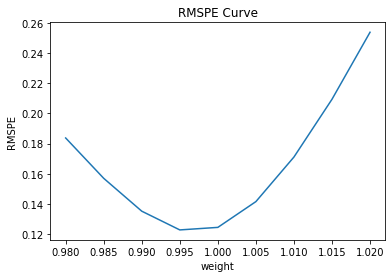

Best weight is 0.995, RMSPE is 0.1228


In [21]:
# correction, see https://www.kaggle.com/c/rossmann-store-sales/discussion/17601#latest-100894
y_pred = reg.predict(X_train_2)
error = rmspe(np.expm1(y_train_2), np.expm1(y_pred))
print("RMSPE: {:.4f}".format(error))
weights = np.arange(0.98, 1.02, 0.005)
errors = []
for w in weights:
    error = rmspe(np.expm1(y_train_2), np.expm1(y_pred * w))
    errors.append(error)
plt.figure()
plt.plot(weights, errors)
plt.xlabel('weight')
plt.ylabel('RMSPE')
plt.title('RMSPE Curve')
plt.show()
print("Best weight is {}, RMSPE is {:.4f}".format(weights[np.argmin(errors)], np.min(errors)))

In [23]:
# private 0.11491 136/3302 top 5%
# public 0.10400 735/3302 top 25%
X_train, y_train = X_train[y_train != 0], y_train[y_train != 0]
reg = xgb.XGBRegressor(n_estimators=2500, objective="reg:squarederror", max_depth=10,
                       learning_rate=0.03, colsample_bytree=0.7, subsample=0.9,
                       random_state=0, tree_method="gpu_hist", gpu_id=0)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train)],
        eval_metric=rmspe_xgb, early_stopping_rounds=50, verbose=50)
pred = np.expm1(reg.predict(X_test) * 0.995)
pred[test_close_ind] = 0
submission = pd.DataFrame({"Id": test_ID, "Sales": pred},
                          columns=["Id", "Sales"])
submission.to_csv("submit/v1_1.csv", index=False)

[0]	validation_0-rmse:8.02106	validation_0-rmspe:0.999809
Multiple eval metrics have been passed: 'validation_0-rmspe' will be used for early stopping.

Will train until validation_0-rmspe hasn't improved in 50 rounds.
[50]	validation_0-rmse:1.77353	validation_0-rmspe:0.820027
[100]	validation_0-rmse:0.453836	validation_0-rmspe:0.360441
[150]	validation_0-rmse:0.231323	validation_0-rmspe:0.254055
[200]	validation_0-rmse:0.187214	validation_0-rmspe:0.23247
[250]	validation_0-rmse:0.162666	validation_0-rmspe:0.206106
[300]	validation_0-rmse:0.145827	validation_0-rmspe:0.181293
[350]	validation_0-rmse:0.132553	validation_0-rmspe:0.160728
[400]	validation_0-rmse:0.124063	validation_0-rmspe:0.15003
[450]	validation_0-rmse:0.116472	validation_0-rmspe:0.142006
[500]	validation_0-rmse:0.110755	validation_0-rmspe:0.135401
[550]	validation_0-rmse:0.106621	validation_0-rmspe:0.130807
[600]	validation_0-rmse:0.103213	validation_0-rmspe:0.125745
[650]	validation_0-rmse:0.100216	validation_0-rmspe:0

In [24]:
# private 0.11447 119/3302 top 4%
# public 0.10340 410/3302 top 20%
pred = np.zeros(X_test.shape[0])
n_models = 10
for i in range(n_models):
    reg = xgb.XGBRegressor(n_estimators=2500, objective="reg:squarederror", max_depth=10,
                           learning_rate=0.03, colsample_bytree=0.7, subsample=0.9,
                           random_state=i, tree_method="gpu_hist", gpu_id=0)
    reg.fit(X_train, y_train, eval_set=[(X_train, y_train)],
            eval_metric=rmspe_xgb, early_stopping_rounds=50, verbose=100)
    pred += np.expm1(reg.predict(X_test) * 0.995)
pred /= n_models
pred[test_close_ind] = 0
submission = pd.DataFrame({"Id": test_ID, "Sales": pred},
                           columns=["Id", "Sales"])
submission.to_csv("submit/v1_2.csv", index=False)

[0]	validation_0-rmse:8.02106	validation_0-rmspe:0.999809
Multiple eval metrics have been passed: 'validation_0-rmspe' will be used for early stopping.

Will train until validation_0-rmspe hasn't improved in 50 rounds.
[100]	validation_0-rmse:0.454069	validation_0-rmspe:0.360307
[200]	validation_0-rmse:0.186485	validation_0-rmspe:0.233662
[300]	validation_0-rmse:0.144982	validation_0-rmspe:0.179754
[400]	validation_0-rmse:0.123063	validation_0-rmspe:0.149378
[500]	validation_0-rmse:0.11125	validation_0-rmspe:0.133904
[600]	validation_0-rmse:0.103022	validation_0-rmspe:0.124036
[700]	validation_0-rmse:0.097945	validation_0-rmspe:0.117037
[800]	validation_0-rmse:0.093977	validation_0-rmspe:0.10984
[900]	validation_0-rmse:0.090769	validation_0-rmspe:0.105265
[1000]	validation_0-rmse:0.088044	validation_0-rmspe:0.101794
[1100]	validation_0-rmse:0.085863	validation_0-rmspe:0.098068
[1200]	validation_0-rmse:0.083878	validation_0-rmspe:0.095168
[1300]	validation_0-rmse:0.082217	validation_0-r

[1700]	validation_0-rmse:0.077084	validation_0-rmspe:0.084852
[1800]	validation_0-rmse:0.075975	validation_0-rmspe:0.083136
[1900]	validation_0-rmse:0.074868	validation_0-rmspe:0.081596
[2000]	validation_0-rmse:0.073813	validation_0-rmspe:0.080131
[2100]	validation_0-rmse:0.072845	validation_0-rmspe:0.078843
[2200]	validation_0-rmse:0.071968	validation_0-rmspe:0.077591
[2300]	validation_0-rmse:0.071118	validation_0-rmspe:0.076317
[2400]	validation_0-rmse:0.070299	validation_0-rmspe:0.075153
[2499]	validation_0-rmse:0.069552	validation_0-rmspe:0.074174
[0]	validation_0-rmse:8.0211	validation_0-rmspe:0.999809
Multiple eval metrics have been passed: 'validation_0-rmspe' will be used for early stopping.

Will train until validation_0-rmspe hasn't improved in 50 rounds.
[100]	validation_0-rmse:0.454001	validation_0-rmspe:0.360698
[200]	validation_0-rmse:0.186213	validation_0-rmspe:0.232447
[300]	validation_0-rmse:0.145756	validation_0-rmspe:0.18289
[400]	validation_0-rmse:0.125136	validatio

[800]	validation_0-rmse:0.093445	validation_0-rmspe:0.107126
[900]	validation_0-rmse:0.090158	validation_0-rmspe:0.102244
[1000]	validation_0-rmse:0.08774	validation_0-rmspe:0.098717
[1100]	validation_0-rmse:0.085529	validation_0-rmspe:0.0956
[1200]	validation_0-rmse:0.083676	validation_0-rmspe:0.092811
[1300]	validation_0-rmse:0.082089	validation_0-rmspe:0.090667
[1400]	validation_0-rmse:0.080625	validation_0-rmspe:0.088668
[1500]	validation_0-rmse:0.079258	validation_0-rmspe:0.086767
[1600]	validation_0-rmse:0.078007	validation_0-rmspe:0.084985
[1700]	validation_0-rmse:0.076796	validation_0-rmspe:0.083364
[1800]	validation_0-rmse:0.075673	validation_0-rmspe:0.081938
[1900]	validation_0-rmse:0.074592	validation_0-rmspe:0.080487
[2000]	validation_0-rmse:0.073629	validation_0-rmspe:0.079223
[2100]	validation_0-rmse:0.072753	validation_0-rmspe:0.078132
[2200]	validation_0-rmse:0.071867	validation_0-rmspe:0.076945
[2300]	validation_0-rmse:0.071029	validation_0-rmspe:0.075897
[2400]	valida